In [2]:
# Denna modul är för att testa olika modeller och parametrar 
# för att hitta den bästa modellen för att förutsäga kryptovalutor
# Dessutom testar jag att ta med inflation och guldpriser som features

# Nu används yfinance för att hämta data från Yahoo Finance

# skall flyttas över till my_crypto.py


In [3]:
import sklearn
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier
# from pytrends.request import TrendReq
# import pytrends
import sys
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import re
import preprocess as pp
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
import plotly.express as px
import streamlit as st
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

#Import other useful libraries
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display
# set display witdh to 200
pd.set_option('display.width', 200)
# set display height to 500
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
# pd.options.display.precision = 4      # default 6
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.INFO, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [4]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__)) # type: ignore
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.5
pandas==1.4.4
matplotlib==3.7.0
yfinance==0.2.12
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.1.1
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


För att hämta från yFinance väljer jag att använda följande tickers för learning och testing:
Mina egna:
['BTC-USD', 'ETH-USD','XRP-USD','BCH-USD','ZRX-USD']

Samt 5 till:
Binance Coin (BNB-USD)
Cardano (ADA-USD)
Dogecoin (DOGE-USD)
Polkadot (DOT-USD)
Avalanche (AVAX-USD)

Ytterligare 5 som får vara reserv:
Solana (SOL-USD)
Chainlink (LINK-USD)
Litecoin (LTC-USD)
Chainlink (LINK-USD)
Polygon (MATIC-USD)

In [5]:
# Dessa 10 kryptovalutor representerar maknaden och blir input till min ML
tickers = ['BTC-USD','ETH-USD','BCH-USD','XRP-USD','ZRX-USD','BNB-USD','ADA-USD','DOGE-USD','DOT-USD', 'AVAX-USD']
horizons=[2, 5, 60, 250]

## Get inflation data US and SE

In [6]:
def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(
        id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['Date'] = pd.to_datetime(inflation['Year'].astype(
        str) + '-' + inflation['month'].astype(str))
    inflation.set_index('Date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(
        inflation, how='left', left_on='Date', right_index=True)
    inflation.set_index('Date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(
        chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation

2023-05-11 19:49:57.657 
  command:

    streamlit run c:\Users\peter\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


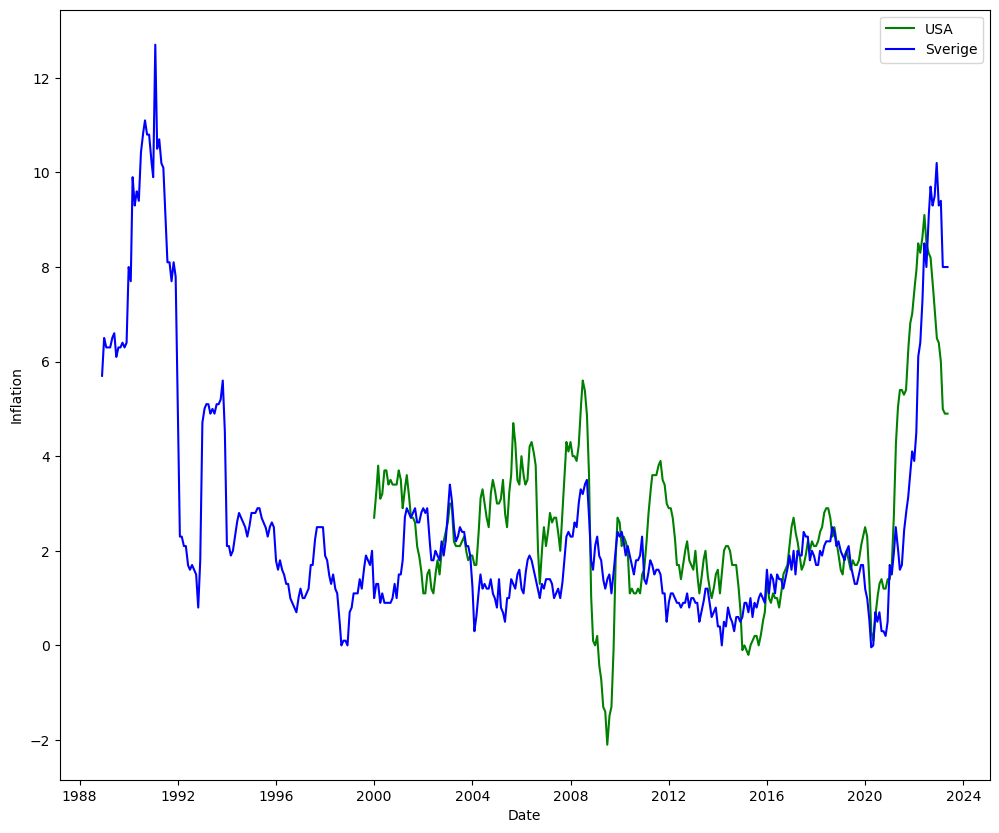

In [7]:

@st.cache_data
def get_inflation_data(graph=False):
    # Explain this function here        
    # Create a dataframe with dates from 1988-12-01 to today
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    # SE_inflation = pd.DataFrame()
    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        # set the color of the liens to blue and green
        ax.plot(US_inflation.index, US_inflation['US_inflation'], color='green', label='USA')
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], color='blue', label='Sverige')
        
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1).copy()
    inflations = inflations.dropna()
    # Keep only US_inflation
    inflations = inflations[['US_inflation']]
    return inflations

df_infl = get_inflation_data(graph=True)

In [8]:
display(list(df_infl.columns))


['US_inflation']

In [9]:
# fill up a dataframe with all days from 2005 up to today and set it as index
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## Get Gold data from yfinance

(6749, 1)

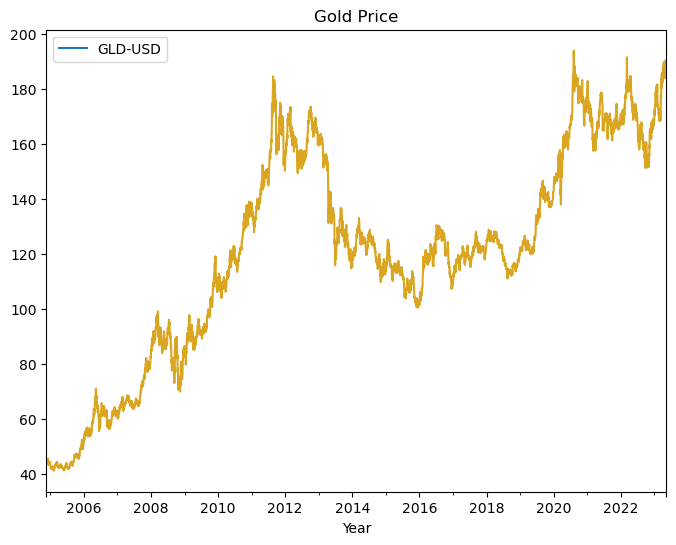

In [10]:
def get_gold_data():
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    df_dates.set_index('Date', inplace=True)
    # Hämta historiska guldprisdata (GLD är ticker-symbolen för SPDR Gold Shares ETF)
    gld_data = yf.download('GLD', end=dt.today().date(), progress=False)
    # gld_data.set_index('Date', inplace=True)
    
    # Behåll endast 'Close' priser och döp om kolumnen till 'GLD-USD'
    gld_data = gld_data[['Close']].rename(columns={'Close': 'GLD-USD'})

    df_dates = pd.DataFrame(pd.date_range(start=gld_data.index[0], end=pd.to_datetime('today').date(), freq='D'), columns=['Date']) # type: ignore

    df_dates.set_index('Date', inplace=True)
    gld_data = df_dates.merge(gld_data, how='left', left_on='Date', right_index=True)
    # interpolating missing values
    gld_data.interpolate(method='linear',inplace=True)
    return gld_data

df_gold = get_gold_data()

display(df_gold.shape)
df_gold.plot(figsize=(8, 6), title='Gold Price')
plt.gca().lines[0].set_color("goldenrod")
plt.xlabel('Year')

plt.show()

## Ladda ner all data

In [11]:
import time
def get_all(tickers):
    # starta timer
    start = time.time()
    # Funktionen används inte just nu    
    df_curr = pd.DataFrame()
    df_vol = pd.DataFrame()
    for ticker in tickers:
        # all_tickers = yf.download(ticker)
        yf_data = yf.download(ticker, period='24mo')
        yf_data = yf_data[['Close', 'Volume']]
        yf_data.columns = [ticker, 'Volume']                   
        df_curr[ticker] = yf_data[ticker]
        df_vol[ticker] = yf_data['Volume']
    df_curr.index = pd.to_datetime(df_curr.index)
    df_vol.index = pd.to_datetime(df_vol.index)
    # skriv ut hur lång tid det tog i sekunder avrundat till 1 decimal
    print(f'Tid för yfinance: {round(time.time() - start, 1)} sekunder')
    return df_curr, df_vol

df_curr, df_vol = get_all(tickers)

# interpolate missing values  
df_curr.interpolate(method='linear',inplace=True)
df_vol.interpolate(method='linear',inplace=True)
print('med yfinance')
display(df_curr.head(3))
display(df_vol.head(3))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Tid för yfinance: 2.0 sekunder
med yfinance


,BTC-USD,ETH-USD,BCH-USD,XRP-USD,ZRX-USD,BNB-USD,ADA-USD,DOGE-USD,DOT-USD,AVAX-USD
Date,,,,,,,,,,
2021-05-11,56704.574219,4168.701172,1542.425049,1.477682,1.861828,672.333923,1.764077,0.495231,38.642284,36.824780
2021-05-12,49150.535156,3785.848633,1209.806885,1.247864,1.626406,588.185181,1.552775,0.385376,34.031391,32.016247
2021-05-13,49716.191406,3715.148438,1251.692139,1.358910,1.613353,571.434509,1.933668,0.490374,40.031654,34.980240


,BTC-USD,ETH-USD,BCH-USD,XRP-USD,ZRX-USD,BNB-USD,ADA-USD,DOGE-USD,DOT-USD,AVAX-USD
Date,,,,,,,,,,
2021-05-11,61308396325,52679737865,8.507115e+09,7973181908,182809865.0,4.865455e+09,5.428572e+09,14566975476,2.263017e+09,342073952.0
2021-05-12,75215403907,69023382175,8.940813e+09,9272699846,298927776.0,4.311561e+09,5.338470e+09,8621337859,3.698746e+09,635368557.0
2021-05-13,96721152926,78398214539,9.987052e+09,12358993946,277607315.0,7.417114e+09,1.451342e+10,18663174069,7.032710e+09,539807645.0


In [12]:
# FOr backtesting
def fit_predict(train, test, target, predictors, model, proba_val=None):
    
    if train[target].nunique() < 2:
        print('kolumner i train',train.columns)
        print('kolumner i test',test.columns)
        print('target',target)
        print('predictors',predictors)
        print('train\n',train[target].value_counts())
        print('test\n',test[target].value_counts())
        print(
            f"Skipping training for target {target} as it has only one unique value in the training data.")
        # stäng ner programmet
        sys.exit()
        
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined


### Beräkna nya kolumner (predictors)

In [13]:
df_curr.tail(3)

,BTC-USD,ETH-USD,BCH-USD,XRP-USD,ZRX-USD,BNB-USD,ADA-USD,DOGE-USD,DOT-USD,AVAX-USD
Date,,,,,,,,,,
2023-05-09,27658.775391,1848.603149,121.977844,0.429888,0.219521,312.513702,0.363806,0.073139,5.328574,15.335583
2023-05-10,27621.755859,1842.401489,116.832195,0.430873,0.216448,308.842331,0.358798,0.073226,5.276260,15.106024
2023-05-11,26796.558594,1778.600586,111.686546,0.414862,0.213375,305.170959,0.353790,0.069969,5.223947,14.876466


In [14]:
### get the data ###
df_curr, df_vol = get_all(tickers)
print('curr:',df_curr.shape)
print('vol:',df_vol.shape)
# inflations = get_inflation_data(graph=False)
print('inflations:',df_infl.shape)
df_gold = get_gold_data()
print('gold:',df_gold.shape)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Tid för yfinance: 2.0 sekunder
curr: (731, 10)
vol: (731, 10)
inflations: (8532, 1)
gold: (6749, 1)


### Vi gör viss preprocessing för en valuta i taget - nya kolumner

In [15]:
### preprocessing ###
df_dict = {}
df = pp.preprocessing_currency(df_curr)
if df is not None:
    print('Antal NaN', df.isna().any().sum())

    print()
    df_dict = {}  # en dictionary med samtlig nya dataframes
    for cnt, column_name in enumerate(df.columns):
        df_name = f'df_{column_name}'
        df_dict[df_name] = pp.preprocess(df_curr[[column_name]],df_vol[[column_name]], df_gold, df_infl)
        print(cnt+1, column_name)

display(df_dict.keys())


10 kolumner totalt
10 kolumner med minst 657 rader utan nan efter dropna
6 rader med någon nan 
725 rader utan nan
Efter interpollate: 0 rader med någon nan 
731 rader utan nan
(731, 10)
Antal NaN 0

1 BTC-USD
2 ETH-USD
3 BCH-USD
4 XRP-USD
5 ZRX-USD
6 BNB-USD
7 ADA-USD
8 DOGE-USD
9 DOT-USD
10 AVAX-USD


dict_keys(['df_BTC-USD', 'df_ETH-USD', 'df_BCH-USD', 'df_XRP-USD', 'df_ZRX-USD', 'df_BNB-USD', 'df_ADA-USD', 'df_DOGE-USD', 'df_DOT-USD', 'df_AVAX-USD'])

In [16]:
df_dict['df_BTC-USD'].head(3)

,BTC-USD,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,Volume,vol_Ratio_2,vol_Ratio_5,vol_Ratio_30,vol_Ratio_60,vol_Ratio_90,vol_Ratio_250,US_inflation,infl_Ratio_75,infl_Ratio_90,infl_Ratio_250,GLD-USD,GLD_Ratio_2,GLD_Ratio_5,GLD_Ratio_30,GLD_Ratio_60,GLD_Ratio_90,GLD_Ratio_250,diff
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-12,49150.535156,0.928638,49150.535156,0.928638,49150.535156,0.928638,49150.535156,0.928638,49150.535156,0.928638,49150.535156,0.928638,49150.535156,75215403907,1.101865,1.101865,1.101865,1.101865,1.101865,1.101865,5.141935,1.251464,1.351822,2.280271,170.429993,0.995008,0.992742,1.017598,1.034009,1.035302,0.990793,0.000000
2021-05-13,49716.191406,1.005721,49433.363281,0.958715,49433.363281,0.958715,49433.363281,0.958715,49433.363281,0.958715,49433.363281,0.958715,49433.363281,96721152926,1.125080,1.244029,1.244029,1.244029,1.244029,1.244029,5.154839,1.244031,1.343047,2.270762,171.130005,1.002049,0.997556,1.020214,1.037294,1.039524,0.995104,0.000000
2021-05-14,49880.535156,1.001650,49798.363281,0.971138,49582.420573,0.971138,49582.420573,0.971138,49582.420573,0.971138,49582.420573,0.971138,49582.420573,55737497453,0.731182,0.771500,0.771500,0.771500,0.771500,0.771500,5.167742,1.236798,1.334502,2.261300,172.690002,1.004537,1.005766,1.027478,1.045642,1.048815,1.004380,215.942708


In [17]:
the_dict = df_dict.copy()
# Slå ihop alla df_dict till  df2 med gemnsamma kolumner
for df_name in the_dict:
    the_dict[df_name] = the_dict[df_name].rename(
        columns={the_dict[df_name].columns[0]: 'Close'})
    # reset index in df_dict[df_name] but keep Date column
    the_dict[df_name] = the_dict[df_name].reset_index(drop=False)
    # add Ticker column to df_dict[df_name]
    the_dict[df_name]['Ticker'] = df_name

df2 = pd.concat(the_dict.values(), axis=0)
df2.sort_values(by=['Date'], inplace=True)
df2.query('Date == "2023-05-01" and Ticker == "df_DOGE-USD"')
df2.set_index('Date', inplace=True)
display(df2.head(3))
display(df2.tail(3))
display(df2.columns)


,Close,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,Volume,vol_Ratio_2,vol_Ratio_5,vol_Ratio_30,vol_Ratio_60,vol_Ratio_90,vol_Ratio_250,US_inflation,infl_Ratio_75,infl_Ratio_90,infl_Ratio_250,GLD-USD,GLD_Ratio_2,GLD_Ratio_5,GLD_Ratio_30,GLD_Ratio_60,GLD_Ratio_90,GLD_Ratio_250,diff,Ticker
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-12,49150.535156,0.928638,49150.535156,0.928638,49150.535156,0.928638,49150.535156,0.928638,49150.535156,0.928638,49150.535156,0.928638,49150.535156,7.521540e+10,1.101865,1.101865,1.101865,1.101865,1.101865,1.101865,5.141935,1.251464,1.351822,2.280271,170.429993,0.995008,0.992742,1.017598,1.034009,1.035302,0.990793,0.0,df_BTC-USD
2021-05-12,3785.848633,0.951870,3785.848633,0.951870,3785.848633,0.951870,3785.848633,0.951870,3785.848633,0.951870,3785.848633,0.951870,3785.848633,6.902338e+10,1.134291,1.134291,1.134291,1.134291,1.134291,1.134291,5.141935,1.251464,1.351822,2.280271,170.429993,0.995008,0.992742,1.017598,1.034009,1.035302,0.990793,0.0,df_ETH-USD
2021-05-12,32.016247,0.930150,32.016247,0.930150,32.016247,0.930150,32.016247,0.930150,32.016247,0.930150,32.016247,0.930150,32.016247,6.353686e+08,1.300063,1.300063,1.300063,1.300063,1.300063,1.300063,5.141935,1.251464,1.351822,2.280271,170.429993,0.995008,0.992742,1.017598,1.034009,1.035302,0.990793,0.0,df_AVAX-USD


,Close,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,Volume,vol_Ratio_2,vol_Ratio_5,vol_Ratio_30,vol_Ratio_60,vol_Ratio_90,vol_Ratio_250,US_inflation,infl_Ratio_75,infl_Ratio_90,infl_Ratio_250,GLD-USD,GLD_Ratio_2,GLD_Ratio_5,GLD_Ratio_30,GLD_Ratio_60,GLD_Ratio_90,GLD_Ratio_250,diff,Ticker
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-11,0.069969,0.977258,0.071598,0.957129,0.073103,0.861204,0.081246,0.877482,0.079739,0.875826,0.079890,0.882380,0.079296,319445920.0,0.962317,1.012139,0.579894,0.488369,0.551823,0.416013,4.9,0.99428,0.978897,0.790578,188.75,1.0,1.002046,1.012394,1.020511,1.04661,1.110303,0.009648,df_DOGE-USD
2023-05-11,111.686546,0.977483,114.259371,0.965660,115.658192,0.916674,121.838960,0.898505,124.302610,0.887559,125.835608,0.943271,118.403510,152288432.0,0.830551,0.912508,1.276325,1.083989,0.926827,0.736173,4.9,0.99428,0.978897,0.790578,188.75,1.0,1.002046,1.012394,1.020511,1.04661,1.110303,11.576237,df_BCH-USD
2023-05-11,14.876466,0.992344,14.991245,0.963635,15.437856,0.847503,17.553286,0.855538,17.388439,0.849584,17.510300,0.908308,16.378223,175514640.0,1.092244,1.129499,0.856170,0.879997,0.810928,0.678228,4.9,0.99428,0.978897,0.790578,188.75,1.0,1.002046,1.012394,1.020511,1.04661,1.110303,2.562041,df_AVAX-USD


Index(['Close', 'Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90', 'Ratio_250', 'Trend_250', 'Volume', 'vol_Ratio_2', 'vol_Ratio_5',
       'vol_Ratio_30', 'vol_Ratio_60', 'vol_Ratio_90', 'vol_Ratio_250', 'US_inflation', 'infl_Ratio_75', 'infl_Ratio_90', 'infl_Ratio_250', 'GLD-USD', 'GLD_Ratio_2', 'GLD_Ratio_5', 'GLD_Ratio_30',
       'GLD_Ratio_60', 'GLD_Ratio_90', 'GLD_Ratio_250', 'diff', 'Ticker'],
      dtype='object')

In [18]:


# compute Tommorow's price to be Close next day
df2['Tomorrow'] = df2.groupby('Ticker')['Close'].shift(-1)

# compute the percentage change
df2['Percentage Change'] = (df2['Tomorrow'] - df2['Close']) / df2['Close'] * 100

df2['y1'] = (df2['Tomorrow'] > df2['Close']).astype(int)
df2.dropna(inplace=True)

### Preprocessing för alla valutor tillsammans

In [19]:
predictors = ['Close', 'Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90',
              'Ratio_250', 'Trend_250', 'GLD-USD', 'GLD_Ratio_2', 'GLD_Ratio_5', 'GLD_Ratio_30', 'GLD_Ratio_60','GLD_Ratio_90', 'GLD_Ratio_250',
              'Volume', 'vol_Ratio_2', 'vol_Ratio_5', 'vol_Ratio_30', 'vol_Ratio_60','vol_Ratio_90', 'vol_Ratio_250',
              'US_inflation', 'infl_Ratio_75', 'infl_Ratio_90', 'infl_Ratio_250', 'diff']


In [24]:
print(len(df2.columns))
len(predictors)
# skillnaden mellan columns och predictors är 'y1', 'Tomorrow', 'Percentage Change'
predictors_diff = [col for col in df2.columns if col not in predictors]
predictors_diff

36


['Ticker', 'Tomorrow', 'Percentage Change', 'y1']

In [25]:

tscv = TimeSeriesSplit(n_splits=5)

In [26]:
l = predictors+['y1']
print(l)
X = df2[l].dropna()
y = X['y1']
X = X.drop(['y1'], axis=1)
print(y.shape)
X.shape

['Close', 'Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90', 'Ratio_250', 'Trend_250', 'GLD-USD', 'GLD_Ratio_2', 'GLD_Ratio_5', 'GLD_Ratio_30', 'GLD_Ratio_60', 'GLD_Ratio_90', 'GLD_Ratio_250', 'Volume', 'vol_Ratio_2', 'vol_Ratio_5', 'vol_Ratio_30', 'vol_Ratio_60', 'vol_Ratio_90', 'vol_Ratio_250', 'US_inflation', 'infl_Ratio_75', 'infl_Ratio_90', 'infl_Ratio_250', 'diff', 'y1']
(7287,)


(7287, 32)

#### Välj mellan GridSearch och RandomSearch

In [27]:
randomsearch = True   # RandmSearchCV för de två tunga modellerna


def combinations(param_list):
    total_combinations = 1
    for key in param_list:
        if key.startswith('classifier__'):
            total_combinations *= len(param_list[key])
    return total_combinations


In [29]:
# Initialize the hyperparameters for each dictionary
# each having a key as ‘classifier’ and value as estimator object.
#The hyperparameter keys should start with the word classifier separated
# by ‘__’ (double underscore)

# Define parameters for CatBoostClassifier
paramCat = {}
paramCat['classifier__iterations'] = [100, 250, 300, 325, 350]
paramCat['classifier__depth'] = [3, 4, 5, 7]
# paramCat['classifier__class_weights'] = [{0: 1, 1: 1}, {0: 1, 1: 2} ]
paramCat['classifier__learning_rate'] = [0.01, 0.03, 0.05, 0.07]
paramCat['classifier'] = [CatBoostClassifier(random_state=42, verbose=False)]
print('Total combinations for CatBoostClassifier = ', combinations(paramCat))

# Define parameters for XGBClassifier
paramXGB = {}
paramXGB['classifier__n_estimators'] = [50, 100, 250,300, 350]
paramXGB['classifier__max_depth'] = [2, 3, 5, 10]
paramXGB['classifier__learning_rate'] = [0.01, 0.03, 0.05, 0.07]
# paramXGB['classifier__scale_pos_weight'] = [1, 5, 10]
paramXGB['classifier'] = [XGBClassifier(
    random_state=42, eval_metric='logloss')]
print('Total combinations for XGBClassifier = ', combinations(paramXGB))


# Define parameters for Random Forest
paramRF = {}
paramRF['classifier__n_estimators'] = [75, 100, 200, 350, 400]
paramRF['classifier__max_depth'] = [ 4, 5, 10, 12]
paramRF['classifier__min_samples_split'] = [2, 5, 10]
paramRF['classifier__min_samples_leaf'] = [1,2,4]
paramRF['classifier__max_features'] = ['auto', 'sqrt']
paramRF['classifier__bootstrap'] = [True, False]
paramRF['classifier'] = [RandomForestClassifier(random_state=42)]
print('Total combinations for RandomForestClassifier = ', combinations(paramRF))

# Define parameters for support vector machine (SVC)
paramSVC = {}
paramSVC['classifier__kernel'] = ['linear', 'rbf']
paramSVC['classifier__C'] = [0.001, 0.01, 1, 10, 100]
paramSVC['classifier__gamma'] = ['scale', 'auto', 0.1, 1, 10]
paramSVC['classifier__shrinking'] = [True, False]
paramSVC['classifier'] = [SVC(random_state=42)]
print('Total combinations for SVC = ', combinations(paramSVC))

# Define parameters for Logistic regression
paramLR = {}
paramLR['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1]
paramLR['classifier__penalty'] = ['l1', 'l2']
paramLR['classifier__solver'] = ['liblinear', 'saga']  # or 'saga'
paramLR['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}]
paramLR['classifier'] = [LogisticRegression(random_state=42)]
print('Total combinations for LogisticRegression = ', combinations(paramLR))

# Define parameters for K neighbors classifier
paramKN = {}
paramKN['classifier__n_neighbors'] = [2, 5, 7, 10, 20]
paramKN['classifier__weights'] = ['uniform', 'distance']
paramKN['classifier__algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']
paramKN['classifier__leaf_size'] = [10, 30, 50]
paramKN['classifier'] = [KNeighborsClassifier()]
print('Total combinations for KNeighborsClassifier = ', combinations(paramKN))

# Define parameters for Gradient boosting
paramGBC = {}
paramGBC['classifier__n_estimators'] = [10, 50, 100, 200, 300]
paramGBC['classifier__max_depth'] = [3, 5, 10, 20]
paramGBC['classifier__min_samples_split'] = [2, 5, 10]
paramGBC['classifier__min_samples_leaf'] = [1, 2, 4]
# paramGBC['classifier__max_features'] = ['auto', 'sqrt', 'log2', None]
# paramGBC['classifier__subsample'] = [0.5, 0.8, 1.0]
# paramGBC['classifier__loss'] = ['deviance', 'exponential']

paramGBC['classifier'] = [GradientBoostingClassifier(random_state=42)]
print('Total combinations for GradientBoostingClassifier = ', combinations(paramGBC))

# define the pipeline to include scaling and the model.
# Prepare the pipeline for the 1st model, others will be loaded appropriately
#during the Grid Search
#This pipeline will be the input to cross_val_score, instead of the model.
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('classifier', RandomForestClassifier(random_state=42)))
pipeline = Pipeline(steps=steps)

#Capture all parameter dictionaries as a list
params = [paramSVC, paramLR, paramKN, paramGBC]
# Total parameters for all 5 models = 27+20+48+5+9 = 109

Total combinations for CatBoostClassifier =  80
Total combinations for XGBClassifier =  80
Total combinations for RandomForestClassifier =  720
Total combinations for SVC =  100
Total combinations for LogisticRegression =  48
Total combinations for KNeighborsClassifier =  120
Total combinations for GradientBoostingClassifier =  180


### GridSearchCV för lätta modeller

In [30]:
# take the time
start_time = time.time()
#Grid search - including cross validation
grid = GridSearchCV(pipeline, params, cv=tscv, n_jobs=-
                    1, scoring='roc_auc').fit(X, y)

#Gridsearch object (in our case 'grid') stores all the information about
#the best model and corresponding hyperparameters.
# print the best parameters...
print(grid.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid.best_score_)

# Stats for each test - we have a total 125 tests
means = grid.cv_results_['mean_test_score']
params_summary = grid.cv_results_['params']
# print the time taken
print("--- %s seconds ---" % round((time.time() - start_time),1))

{'classifier': GradientBoostingClassifier(max_depth=10, min_samples_leaf=2,
                           min_samples_split=10, random_state=42), 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
0.539544847577291
--- 2171.5 seconds ---


In [31]:

#Capture all data into a Data Frame
df_res1 = pd.DataFrame(list(zip(means, params_summary)),
                  columns=['Mean Score', 'Parms']).sort_values(by=['Mean Score'], ascending=False)

In [32]:
df_res1 = df_res1.sort_values(by='Mean Score', ascending=False)
df_res1.to_csv('GridSearchResults1.csv', index=False)

In [33]:
df_res1 = pd.read_csv('GridSearchResults1.csv')

df_res1.head()

,Mean Score,Parms
0,0.539545,"{'classifier': GradientBoostingClassifier(max_depth=10, ..."
1,0.537967,"{'classifier': GradientBoostingClassifier(max_depth=10, ..."
2,0.536591,"{'classifier': GradientBoostingClassifier(max_depth=10, ..."
3,0.535094,"{'classifier': GradientBoostingClassifier(max_depth=10, ..."
4,0.534010,"{'classifier': GradientBoostingClassifier(max_depth=10, ..."


### RandomizedSearchCV av de två tunga modellerna

In [34]:
if randomsearch:
    from sklearn.model_selection import RandomizedSearchCV

    # Add the new parameter dictionaries to the list
    params = [paramCat, paramXGB, paramRF]

    # Number of iterations for randomized search
    n_iter_search = 50

    #### Random search RF - including cross validation ####
    # Take the time
    start_time = time.time()
    randomRF = RandomizedSearchCV(
        pipeline, param_distributions=params[2], n_iter=n_iter_search, cv=tscv, n_jobs=-1, scoring='roc_auc', random_state=42).fit(X, y)

    # print the best parameters...
    print(randomRF.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(randomRF.best_score_)

    # Stats for each test - we have a total 48 tests
    meansRF = randomRF.cv_results_['mean_test_score']
    params_summaryRF = randomRF.cv_results_['params']

    #Capture all data into a Data Frame
    df_resRF = pd.DataFrame(list(zip(meansRF, params_summaryRF)),
                            columns=['Mean Score', 'Parms'])

    # Take the time
    print("--- The RF time was %s seconds ---" %round((time.time() - start_time), 1))
    df_resRF = df_resRF.sort_values(by='Mean Score', ascending=False)
    df_resRF.to_csv('RandomSearchResultsRF.csv', index=False)

    display(df_resRF.head())
    
    
    #### Random search XGB - including cross validation ####
    # Take the time
    start_time = time.time()
    randomXGB = RandomizedSearchCV(
        pipeline, param_distributions=params[1], n_iter=n_iter_search, cv=tscv, n_jobs=-1, scoring='roc_auc', random_state=42).fit(X, y)

    # print the best parameters...
    print(randomXGB.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(randomXGB.best_score_)

    # Stats for each test - we have a total 48 tests
    meansXGB = randomXGB.cv_results_['mean_test_score']
    params_summaryXGB = randomXGB.cv_results_['params']

    #Capture all data into a Data Frame
    df_resXGB = pd.DataFrame(list(zip(meansXGB, params_summaryXGB)),
                            columns=['Mean Score', 'Parms'])

    # Take the time
    print("--- The XGB time was %s seconds ---" % round((time.time() - start_time), 1))
    df_resXGB = df_resXGB.sort_values(by='Mean Score', ascending=False)
    df_resXGB.to_csv('RandomSearchResultsXGB.csv', index=False)

    display(df_resXGB.head())

    #### Random search CATB - including cross validation ####
    # Take the time
    start_time = time.time()
    randomCAT = RandomizedSearchCV(
        pipeline, param_distributions=params[0], n_iter=n_iter_search, cv=tscv, n_jobs=-1, scoring='roc_auc', random_state=42).fit(X, y)

    # print the best parameters...
    print(randomCAT.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(randomCAT.best_score_)

    # Stats for each test - we have a total 144 tests
    mensCAT = randomCAT.cv_results_['mean_test_score']
    params_summaryCAT = randomCAT.cv_results_['params']

    #Capture all data into a Data Frame
    df_resCAT = pd.DataFrame(list(zip(mensCAT, params_summaryCAT)),
                            columns=['Mean Score', 'Parms'])
    df_resCAT =df_resCAT.sort_values(by='Mean Score', ascending=False)  
    df_resCAT.to_csv('RandomSearchResultsCAT.csv', index=False)

    display(df_resCAT.head())
    # Take the time
    print("--- The Cat time was %s seconds ---" % round((time.time() - start_time), 1))


{'classifier__n_estimators': 400, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10, 'classifier__bootstrap': True, 'classifier': RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=400, random_state=42)}
0.534566517372838
--- The RF time was 83.9 seconds ---


,Mean Score,Parms
26,0.534567,"{'classifier__n_estimators': 400, 'classifier__min_sampl..."
34,0.534244,"{'classifier__n_estimators': 100, 'classifier__min_sampl..."
37,0.534048,"{'classifier__n_estimators': 400, 'classifier__min_sampl..."
38,0.534043,"{'classifier__n_estimators': 350, 'classifier__min_sampl..."
17,0.534015,"{'classifier__n_estimators': 200, 'classifier__min_sampl..."


{'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.07, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)}
0.5504198257673144
--- The XGB time was 125.9 seconds ---


,Mean Score,Parms
40,0.550420,"{'classifier__n_estimators': 100, 'classifier__max_depth..."
30,0.550019,"{'classifier__n_estimators': 100, 'classifier__max_depth..."
47,0.549250,"{'classifier__n_estimators': 100, 'classifier__max_depth..."
29,0.548528,"{'classifier__n_estimators': 350, 'classifier__max_depth..."
43,0.547725,"{'classifier__n_estimators': 300, 'classifier__max_depth..."


{'classifier__learning_rate': 0.07, 'classifier__iterations': 100, 'classifier__depth': 3, 'classifier': <catboost.core.CatBoostClassifier object at 0x0000020425BD8C40>}
0.5409864165475274


,Mean Score,Parms
41,0.540986,"{'classifier__learning_rate': 0.07, 'classifier__iterati..."
25,0.538593,"{'classifier__learning_rate': 0.05, 'classifier__iterati..."
31,0.538439,"{'classifier__learning_rate': 0.07, 'classifier__iterati..."
40,0.537877,"{'classifier__learning_rate': 0.01, 'classifier__iterati..."
32,0.537126,"{'classifier__learning_rate': 0.07, 'classifier__iterati..."


--- The Cat time was 141.9 seconds ---


### GridSearchCV även för de tunga

In [35]:
if not randomsearch:
    # Make GridSearch one by one for each model - because it takes so long time
    params = [paramCat, paramXGB, paramRF]

    #### search XGB ####
    start_time = time.time()
    grid2a = GridSearchCV(pipeline, params, cv=tscv, n_jobs=-
                        1, scoring='roc_auc').fit(X, y)

    # print the best parameters...
    print(grid2a.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(grid2a.best_score_)

    # Stats for each test - we have a total 48 tests
    means2a = grid2a.cv_results_['mean_test_score']
    params_summary2a = grid2a.cv_results_['params']

    #Capture all data into a Data Frame
    df_resRF = pd.DataFrame(list(zip(means2a, params_summary2a)),
                    columns=['Mean Score', 'Parms'])

    df_resRF.to_csv('GridSearchResults2a.csv', index=False)

    # Take the time
    print("--- The time was %s seconds ---" % round((time.time() - start_time),1))
    
    df_resRF = pd.read_csv('GridSearchResults2a.csv').sort_values(
        by='Mean Score', ascending=False)

    df_resRF.head()


In [36]:
if not randomsearch:
    #### Grid search CATB ####
    # Take the time
    start_time = time.time()
    grid2b = GridSearchCV(pipeline, params[:1], cv=tscv, n_jobs=-
                        1, scoring='roc_auc').fit(X, y)
    # print the best parameters...
    print(grid2b.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(grid2b.best_score_)

    # Stats for each test - we have a total 144 tests
    meansXGB = grid2b.cv_results_['mean_test_score']
    params_summaryXGB = grid2b.cv_results_['params']

    #Capture all data into a Data Frame
    df_resXGB = pd.DataFrame(list(zip(meansXGB, params_summaryXGB)), # type: ignore
                            columns=['Mean Score', 'Parms'])

    df_resXGB.to_csv('GridSearchResults2b.csv', index=False)

    # Take the time
    print("--- The time was %s seconds ---" % round((time.time() - start_time),1))

### Summera alla modellers performance

In [37]:
df_res1 = pd.read_csv('GridSearchResults1.csv')

if randomsearch:
    df_resRF = pd.read_csv('RandomSearchResultsRF.csv')
    df_resRF['Model'] = 'RandomForrestClassifier'
    df_resXGB = pd.read_csv('RandomSearchResultsXGB.csv')
    df_resXGB['Model'] = 'XGBoost_Classifier'
    df_resCAT = pd.read_csv('RandomSearchResultsCAT.csv')
    df_resCAT['Model'] = 'CatBoostClassifier'
else:
    df_resRF = pd.read_csv('GridSearchResults2a.csv')
    df_resRF['Model'] = 'WARNING change this'
    df_resXGB = pd.read_csv('GridSearchResults2b.csv')
    df_resXGB['Model'] = 'WARNING change this'
    df_resCAT = pd.DataFrame()

df_res = pd.concat([df_res1, df_resRF, df_resXGB, df_resCAT], ignore_index=True).sort_values(
    by='Mean Score', ascending=False)
df_res.to_csv('GridSearchResults.csv', index=False)


def extract_model_and_params(row):
    model_regex = r'\'classifier\':\s*([^,]+)'
    param_regex = r'\'classifier__([a-zA-Z0-9_]+)\':\s*([^,}]+)'

    model_match = re.search(model_regex, row['Parms'])
    model = model_match.group(1) if model_match else 'Unknown'
    # print(type(row.Model))
    model = 'CatBoostClassifier' if 'CatBoostClassifier' == row.Model else model
    model = 'XGBoost_Classifier' if 'XGBoost_Classifier' == row.Model else model
    model = 'RandomForrestClassifier' if 'RandomForrestClassifier' == row.Model else model
    # Ersätt objektreferenser med klassnamn
    model = re.sub(r'<[^>]*>', lambda x: 'CatBoostClassifier' if 'catboost' in x.group(0)
                   else x.group(0).split('.')[1], model)
    # print(model)
    # Ta bort allt efter och inklusive '('
    model = re.sub(r'\(.*|\}.*', '', model).strip()

    params = re.findall(param_regex, row['Parms'])
    params_clean = {k: v.strip() for k, v in params}
    # print(params_clean)
    return pd.Series([model, params_clean])

print(df_res.columns)
print(df_res.Model.unique())


Index(['Mean Score', 'Parms', 'Model'], dtype='object')
['XGBoost_Classifier' 'CatBoostClassifier' nan 'RandomForrestClassifier']


In [38]:

# Skapa nya kolumner för model och parametrar utan 'classifier__' prefix

df_res[['Model', 'Parameters_clean']] = df_res.apply(extract_model_and_params, axis=1)
df_res.sort_values(by='Mean Score', ascending=False, inplace=True)
# Ta bort den gamla 'Parameters' kolumnen
df_res = df_res.drop(columns=['Parms'])

print(
    f'The winner is {df_res.iloc[0].Model} with params\n {df_res.iloc[0]["Parameters_clean"]}')

print()
pd.set_option('display.max_colwidth', None)
print('De bästa resultaten per modell sorterade efter Mean Score')
m = df_res.groupby('Model').head(1).sort_values(by='Mean Score', ascending=False)
print(m[['Model', 'Mean Score', 'Parameters_clean']].to_string(index=False))


The winner is XGBoost_Classifier with params
 {'n_estimators': '100', 'max_depth': '10', 'learning_rate': '0.07'}

De bästa resultaten per modell sorterade efter Mean Score
                     Model  Mean Score                                                                                                                              Parameters_clean
        XGBoost_Classifier    0.550420                                                                           {'n_estimators': '100', 'max_depth': '10', 'learning_rate': '0.07'}
        CatBoostClassifier    0.540986                                                                                  {'learning_rate': '0.07', 'iterations': '100', 'depth': '3'}
GradientBoostingClassifier    0.539545                                                {'max_depth': '10', 'min_samples_leaf': '2', 'min_samples_split': '10', 'n_estimators': '100'}
   RandomForrestClassifier    0.534567 {'n_estimators': '400', 'min_samples_split': '10', 'min_samples_

In [39]:

'''
Cat    0.538938 {'learning_rate': '0.05', 'iterations': '300', 'depth': '5', 'class_weights': '{0: 1'}
LR     0.528211 {'C': '0.01', 'class_weight': '{0: 1', 'penalty': ''l1'', 'solver': ''saga''}
XGB    0.528148 {'scale_pos_weight': '1', 'n_estimators': '250', 'max_depth': '3'}
RF     0.518698 {'class_weight': 'None', 'max_depth': '5', 'n_estimators': '350'}
SVC    0.515697 {'C': '0.1', 'class_weight': '{0: 1'}
GBC    0.535747   {'max_depth': '5', 'min_samples_leaf': '4', 'min_samples_split': '2', 'n_estimators': '300'}
KNC    0.505451 {'n_neighbors': '2'}
'''


"\nCat    0.538938 {'learning_rate': '0.05', 'iterations': '300', 'depth': '5', 'class_weights': '{0: 1'}\nLR     0.528211 {'C': '0.01', 'class_weight': '{0: 1', 'penalty': ''l1'', 'solver': ''saga''}\nXGB    0.528148 {'scale_pos_weight': '1', 'n_estimators': '250', 'max_depth': '3'}\nRF     0.518698 {'class_weight': 'None', 'max_depth': '5', 'n_estimators': '350'}\nSVC    0.515697 {'C': '0.1', 'class_weight': '{0: 1'}\nGBC    0.535747   {'max_depth': '5', 'min_samples_leaf': '4', 'min_samples_split': '2', 'n_estimators': '300'}\nKNC    0.505451 {'n_neighbors': '2'}\n"

In [40]:
df_res.Model.unique()


array(['XGBoost_Classifier', 'CatBoostClassifier',
       'GradientBoostingClassifier', 'RandomForrestClassifier',
       'LogisticRegression', 'SVC', 'KNeighborsClassifier'], dtype=object)

TODO: Lista följer - 
1. Välj ut en modell: CatBoost    
   'learning_rate': '0.03', 'iterations': '250', 'depth': '3'
2. Överför till my_crypto.py som skall ha en pipeline för transform enligt ChatGpt
3. Kör ML på de 10 utvalda valutorna vars Close-värden hämtas från 
4. Just skapar jag en ny StandardScler separat för Train men jag skall nog använda den som är sparad i scalers-foldern
5. preprocessing finns i preprocess.py

# Tester